#### A step by step explanation of backpropagation and training of neural networks. Follows a video by Andrej Karpathy found here: https://youtu.be/VMj-3S1tku0

In [192]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### How a derivative works

In [193]:
def f(x):
    return 3*x**2 - 4*x + 5

In [194]:
f(3.0)

20.0

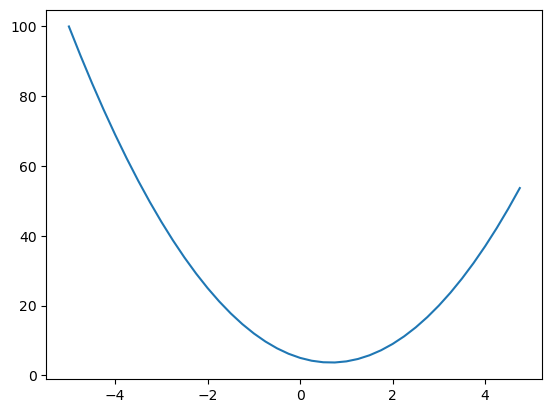

In [195]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [196]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [197]:
# Get more complex
a = 2.0
b = -3.0
c = 18.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

d1 12.0
d2 11.99997


## Value class

In [198]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward

        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
d
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L
   

Value(-8.0)

In [199]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ("record") node for it
        dot.node(name = uid, label = f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

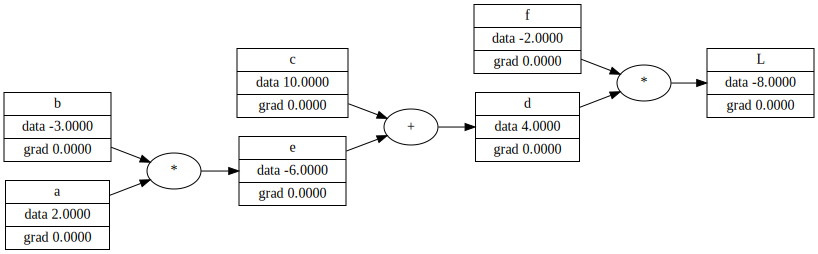

In [200]:
draw_dot(L)

### Manual backpropagation

In [201]:
def lol():
    
    h = 0.00001    

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    b.data += h
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-4.000000000026205


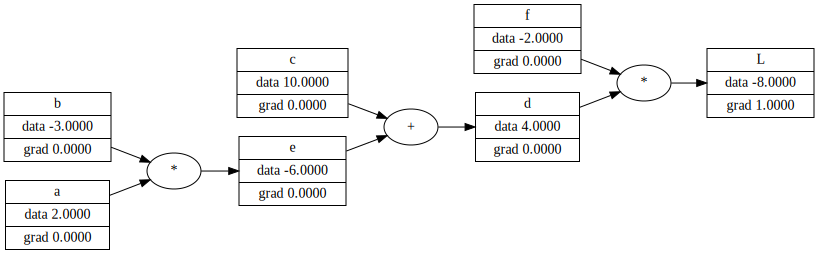

In [202]:
L.grad = 1.0
draw_dot(L)

#### How to find the derivative of L relative to d

L = d * f

dL / dd =? f

dL / df =? d

(f(x+h)) - f(x)) / h

((d+h)*f - d*f) / h

(d*f + h*f - d*f) / h

(h*f) / h

f

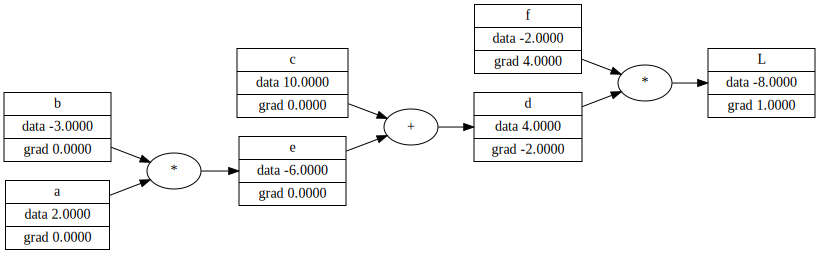

In [203]:
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

#### How to find the derivative of c and e relative to d

dd / dc =? 1.0

dd / de =? 1.0

d = c + e

f(x+h) - f(x) / h

((c+h + e) - (c + e)) / h

(c + h + e - c -e) / h

h/h

1.0

#### How to find dL / dc

WANT: 

dL / dc = (dL / dd) * (dd / dc) # chain rule

so, dL / dc = f * 1.0 = f

and, dL / de = f * 1.0 = f

KNOW: 

dL / dd = f

dd / dc = 1.0

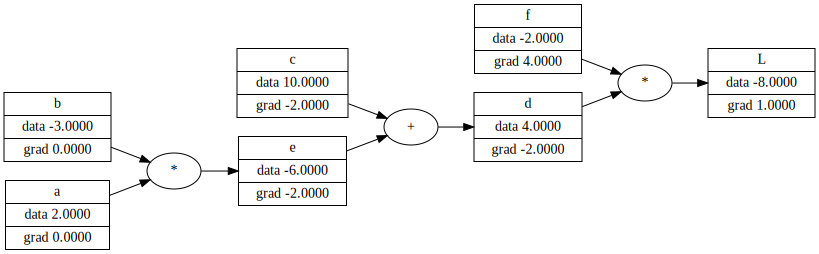

In [204]:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

KNOW: 

dL / de = -2.0

e = a * b

de / da =? b

WANT:

dL / da = (dL / de) * (de / da) # chain rule

so, dL / da = -2.0 * -3.0 = 6.0

and, dL / db = -2.0 * 2.0 = -4.0

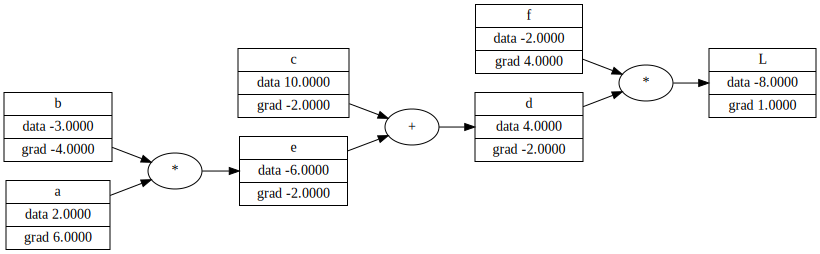

In [205]:
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

### Manual backpropagation through a neuron

In [206]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


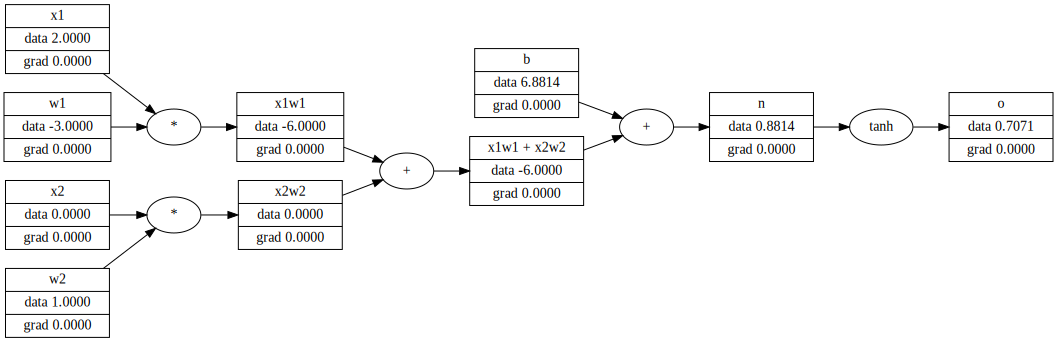

In [207]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)

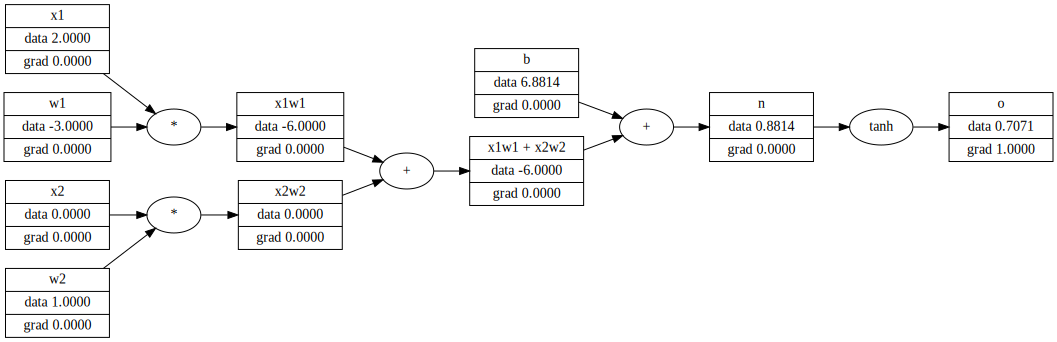

In [208]:
o.grad = 1.0
draw_dot(o)

o = tanh(n)

do/dn = 1 - tanh(n)^2 = 1 - o^2

In [209]:
1 - o.data**2

0.4999999999999999

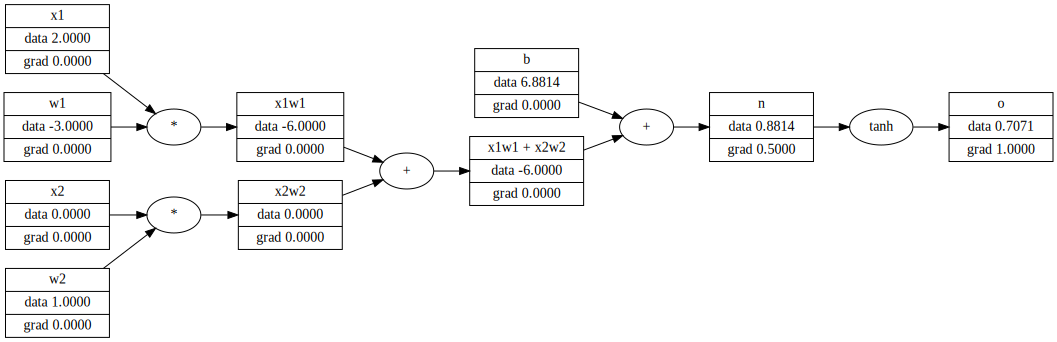

In [210]:
n.grad = 0.5
draw_dot(o)

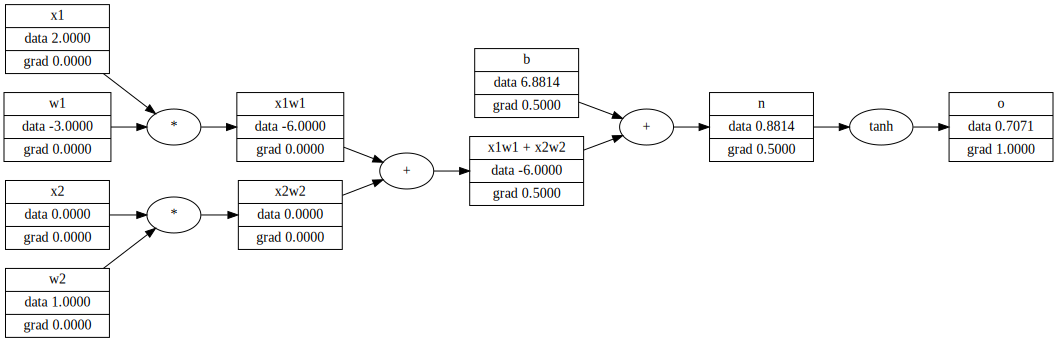

In [211]:
## x1w1 + x2w2 + b = n, so
x1w1x2w2.grad = 0.5
b.grad = 0.5
draw_dot(o)

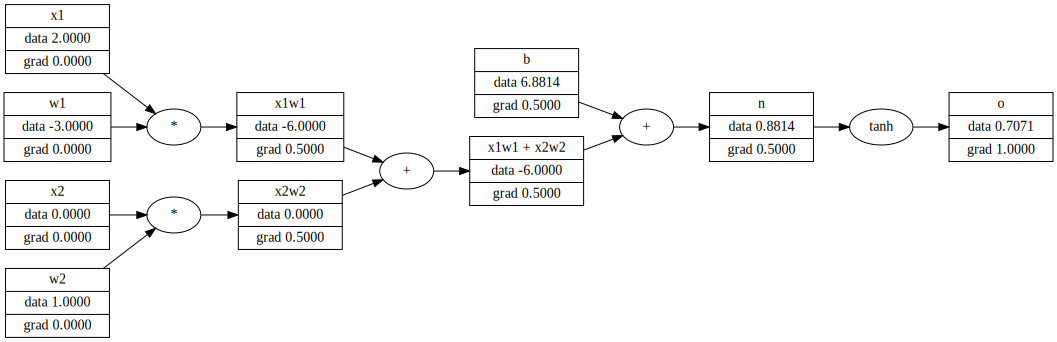

In [212]:
# x1w1 + x2w2 = x1w1x2w2, so
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

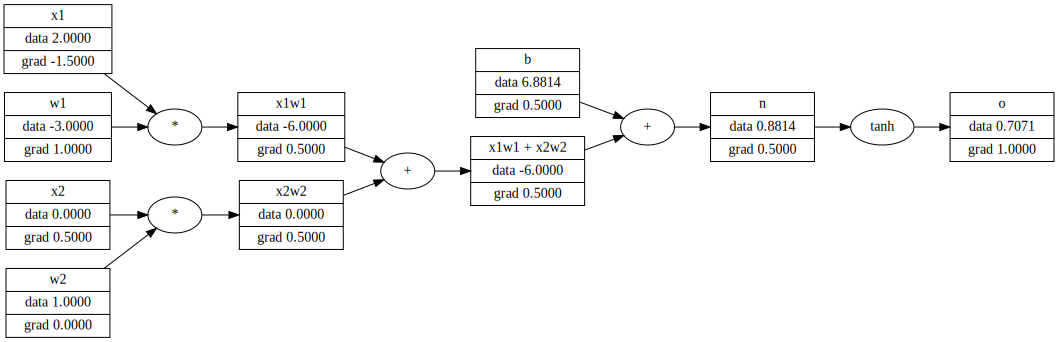

In [213]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
draw_dot(o)

#### Implementing the backwards function

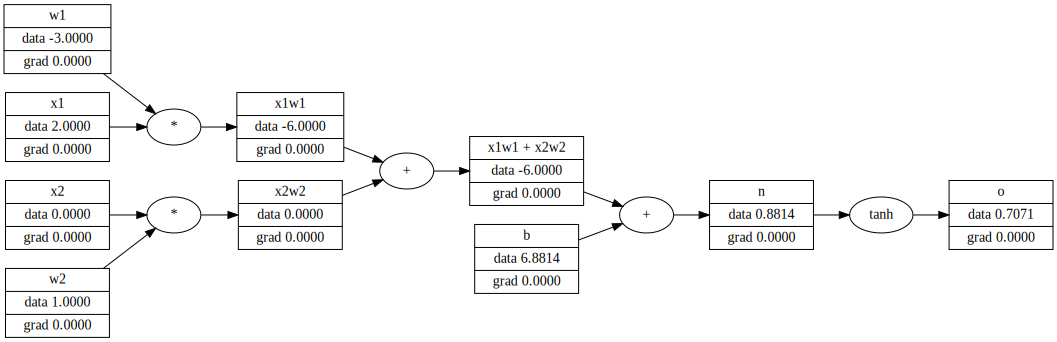

In [214]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)

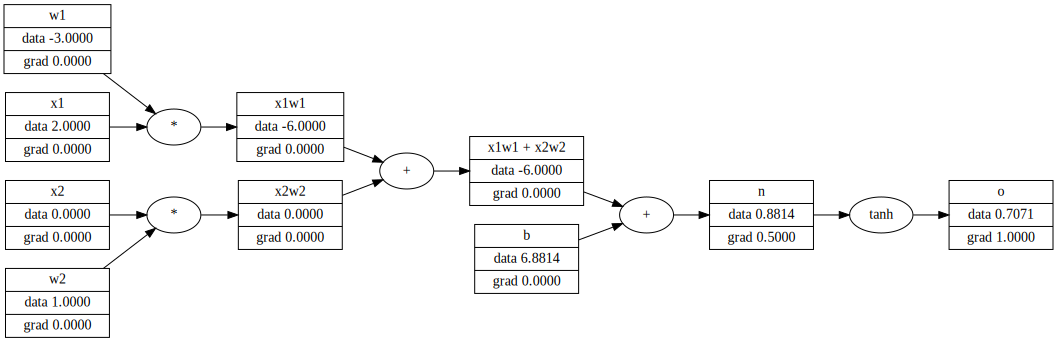

In [218]:
o.grad = 1.0
o._backward()
draw_dot(o)

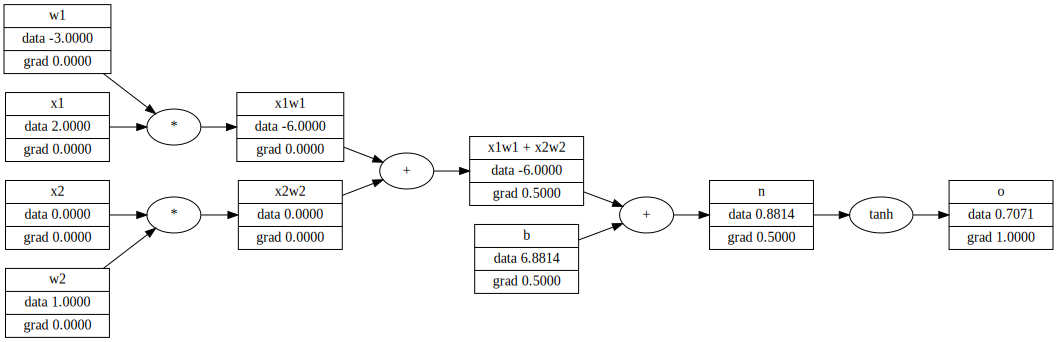

In [219]:
n._backward()
draw_dot(o)

In [220]:
b._backward()

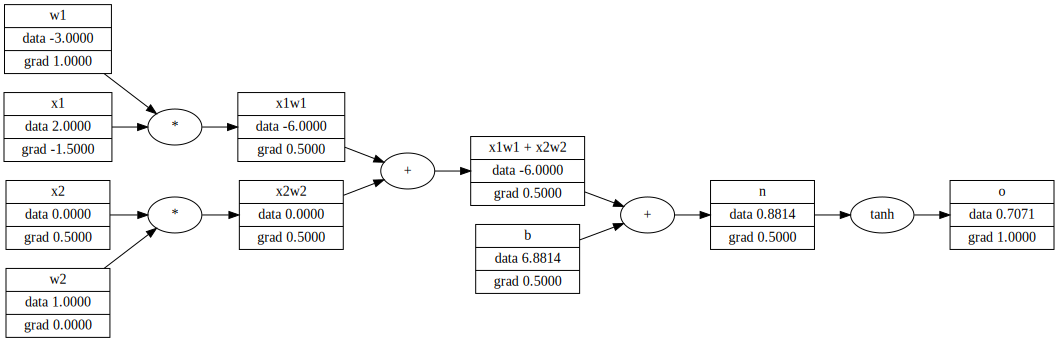

In [222]:
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)